In [1]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from qiskit import Aer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.algorithms.optimizers import COBYLA
from qiskit_machine_learning.datasets import breast_cancer
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, TwoLocal
from sklearn.preprocessing import OneHotEncoder
from qiskit_machine_learning.algorithms.classifiers import VQC

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

seed = 12345
algorithm_globals.random_seed = seed

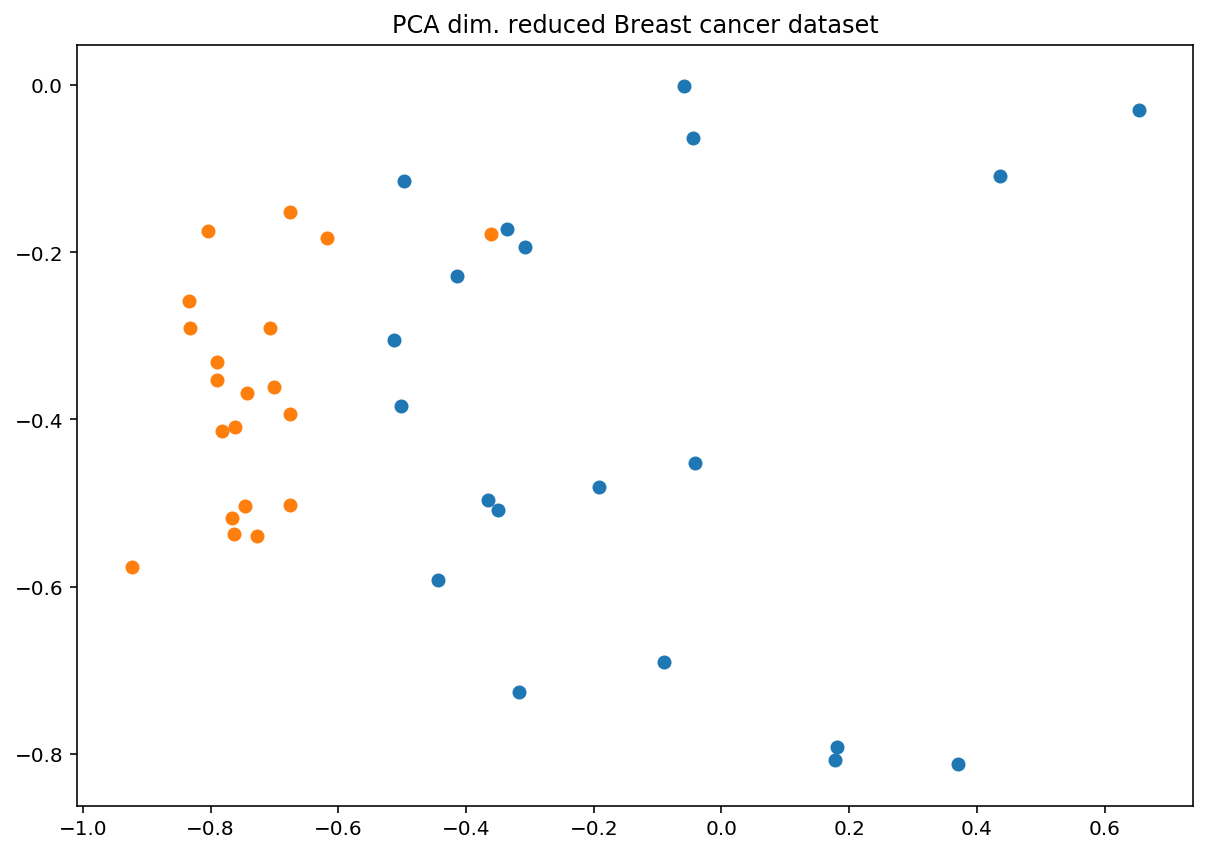

In [2]:
dimension = 2

training_feature_array, training_label_array, test_feature_array, test_label_array = breast_cancer(
    training_size=20,
    test_size=5,
    n=dimension,
    plot_data=True,
    one_hot=False,
)

In [3]:
ohe_transformer = OneHotEncoder(sparse = False)
training_label_array = ohe_transformer.fit_transform(training_label_array.reshape(-1,1))
training_label_array[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [4]:
training_label_array.shape

(40, 2)

In [5]:
training_feature_array.shape

(40, 2)

In [6]:
features = training_feature_array.shape[1]
features

2

In [7]:
optimizer = COBYLA(maxiter = 120, tol = 0.001)

In [8]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait = True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

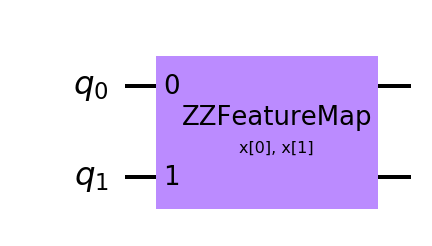

In [9]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = features, reps = 1, entanglement = "full")
ZZ_feature_map.draw('mpl')

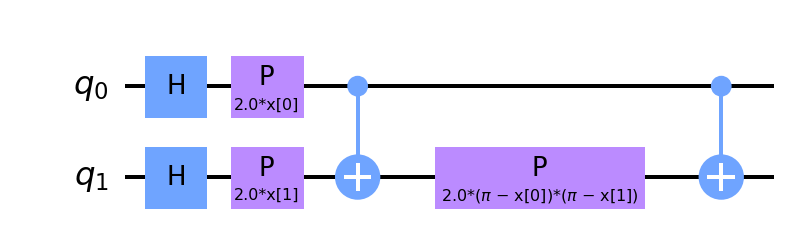

In [10]:
ZZ_feature_map.decompose().draw('mpl')

In [11]:
num_qubits = features
variational_circ = RealAmplitudes(num_qubits = num_qubits, reps = 4, entanglement = "full")
#variational_circ = EfficientSU2(num_qubits = num_qubits, reps = 4, entanglement = "full")
#variational_circ = TwoLocal(ZZ_feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3)

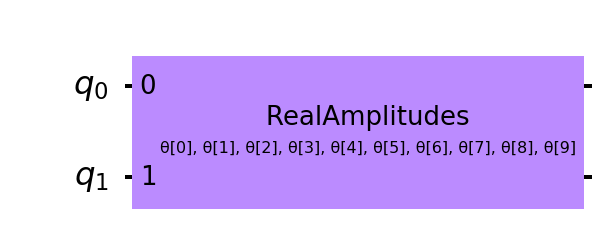

In [12]:
variational_circ.draw('mpl')

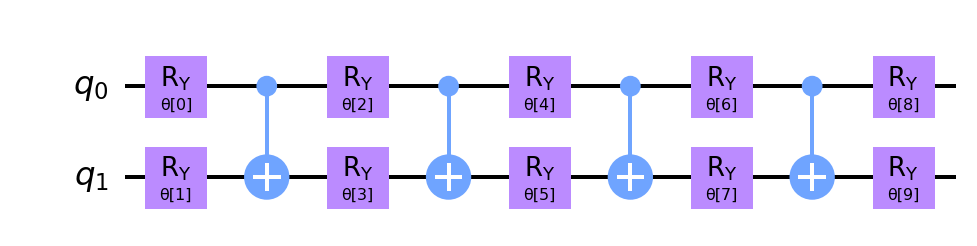

In [13]:
variational_circ.decompose().draw('mpl')

In [14]:
backend = Aer.get_backend('statevector_simulator')

In [15]:
quantum_instance = QuantumInstance(backend, 
                                   shots = 1024, 
                                   seed_simulator = algorithm_globals.random_seed, 
                                   seed_transpiler = algorithm_globals.random_seed)

In [16]:
variational_circ.num_parameters

10

In [17]:
initial_point = algorithm_globals.random.random(variational_circ.num_parameters)

In [18]:
vqc = VQC(feature_map = ZZ_feature_map,
         ansatz = variational_circ,
         optimizer = optimizer,
         quantum_instance = quantum_instance,
         initial_point = initial_point,
         callback = callback_graph)

In [19]:
start = time.time()

In [20]:
training_feature_array

array([[-1.91722314e-01, -4.80476381e-01],
       [-8.93167493e-02, -6.90472760e-01],
       [-5.01242223e-01, -3.84046326e-01],
       [-4.52465569e-02, -6.29986060e-02],
       [-3.65034765e-01, -4.96668601e-01],
       [-4.43185748e-01, -5.91643538e-01],
       [-4.14652398e-01, -2.27906371e-01],
       [ 1.80708674e-01, -7.91194568e-01],
       [-5.91668778e-02, -8.75079606e-04],
       [ 1.77020707e-01, -8.07823025e-01],
       [-3.36560832e-01, -1.71919846e-01],
       [ 4.35619573e-01, -1.08787534e-01],
       [ 3.69755604e-01, -8.12622486e-01],
       [ 6.53567209e-01, -3.02768895e-02],
       [-4.11899710e-02, -4.52141139e-01],
       [-4.97422037e-01, -1.14413144e-01],
       [-5.13358689e-01, -3.05153633e-01],
       [-3.16661686e-01, -7.26526139e-01],
       [-3.50475509e-01, -5.08564098e-01],
       [-3.07041694e-01, -1.93485539e-01],
       [-8.03815886e-01, -1.74967364e-01],
       [-8.33344797e-01, -2.58764992e-01],
       [-7.07308042e-01, -2.90544628e-01],
       [-7.

In [21]:
test_feature_array

array([[-0.10389794,  0.17924751],
       [-0.53086407, -0.4573074 ],
       [-0.21040012, -0.42492679],
       [-0.02115007, -0.46893251],
       [-0.20818445, -0.4872755 ],
       [-0.82652554, -0.4336021 ],
       [-0.73291597, -0.5064755 ],
       [-0.90409716, -0.00762145],
       [-0.7863327 , -0.3957758 ],
       [-0.53303533, -0.39673394]])

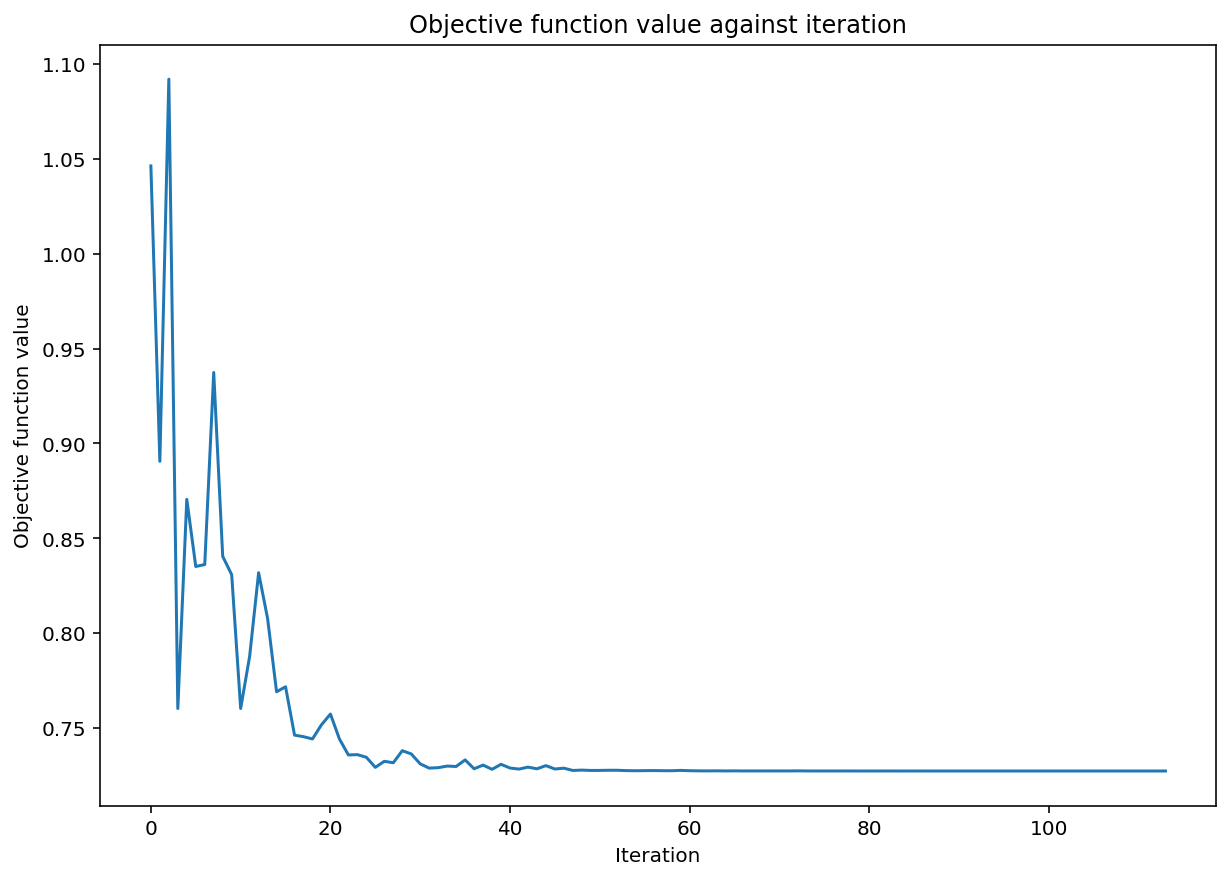

Time elapsed:  35.22103476524353


In [22]:
objective_func_vals = []

vqc.fit(training_feature_array, training_label_array)

elapsed = time.time() - start

print("Time elapsed: ", elapsed)

plt.show()

In [23]:
test_label_array_temp = ohe_transformer.fit_transform(test_label_array.reshape(-1,1))

score = vqc.score(test_feature_array, test_label_array_temp)

print(f"Testing accuracy: {score:0.2f}")

Testing accuracy: 0.90


In [25]:
score = vqc.score(training_feature_array, training_label_array)

print(f"Testing accuracy: {score:0.2f}")

Testing accuracy: 0.85
